Grace's solution to solving Anna's ODE; no noise

In [2]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC

For my ODE, I've chosen a simple model of exponential decay:
$u' = -au$


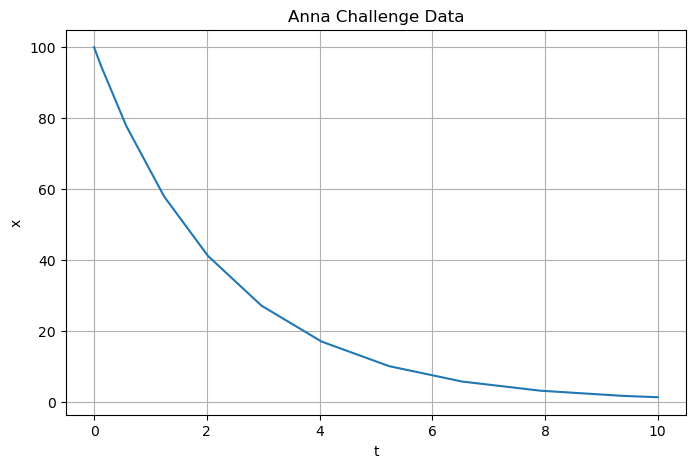

In [3]:
data = pd.read_csv("/Users/gracerojo/Downloads/DiffEqThings/anna_ode_challenge_1_data.csv")

t = data["timestamp"]
x_true = data["value"]


plt.figure(figsize=(8,5))
plt.plot(t,x_true)
plt.title('Anna Challenge Data')
plt.xlabel('t')
plt.ylabel('x')
plt.grid()
plt.show()

In [4]:
def diffyqs(X, t, epsilon): # fn to pass to solver (essentially identical to the Julia solver but indexed different)
    # x, vx = X[0], X[1]
    x = X[0]
    dx = - epsilon * x
    # dv = -beta*x - epsilon * x**3
    return dx

In [5]:
initial_condition = 100.0

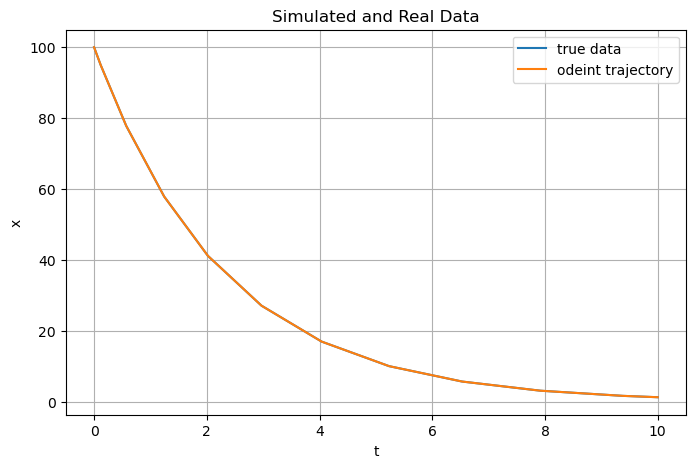

In [6]:
epsilon = .44
# beta = epsilon

sol = odeint(diffyqs, initial_condition, t, args=(epsilon,)) # pass odeint the differential equation, initial condition, time array, and parameters

# plot plot plot
plt.figure(figsize=(8,5))
plt.plot(t,x_true, label = 'true data')
plt.plot(t,sol.T[0], label = 'odeint trajectory') # to get the right part of the solution you have to do this weird transpose index thing
plt.title('Simulated and Real Data')
plt.xlabel('t')
plt.ylabel('x')
plt.legend()
plt.grid()
plt.show()

## Now let's use PyVBMC

In [7]:
def log_likelihood(theta):
    epsilon = theta # unpack parameters from theta

    # sigma = 0.2 # we just know this from when I added gaussian noise to the data, not sure how you would get this in practice (error bars??)

    sol = odeint(diffyqs, initial_condition, t, args=(epsilon,)) # get solution of ODE with current choice of params
    
    return np.sum(- (sol.T[0] - x_true)**2) # normal distribution

In [8]:
D = 1  # 2-D since there are 2 params we're estimating

prior_mu =  np.full((1,D), 5.0) # Mean of the prior (in theory, I think rn this is just being used to get PLB, PUB)  #np.zeros((1, D))
prior_std = 2 * np.ones((1, D)) # std of the prior

LB = np.full((1, D), 0.0)  # Lower bounds (we know from the model that they have to be positive, negative values would break odeint)
# LB[0][2] = -4.0
UB = np.full((1, D), 10.0)  # Upper bounds (picked to be reasonable)
# UB[0][2] = 4.0

PLB =  prior_mu - prior_std  # Plausible lower bounds     # PLB = scs.norm.ppf(0.1587, prior_mu, prior_std)
PUB =  prior_mu + prior_std  # Plausible upper bounds     # PUB = scs.norm.ppf(0.8413, prior_mu, prior_std)
# PLB[0][2] = -2.0
# PUB[0][2] = 2.0


x0 = np.copy(prior_mu) # starting point for inference   # 1.5 * np.ones((1, D))
# x0[0][2] = 0.2

In [9]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = UniformBox(LB, UB)) # initialize VMBC object

vp, results = vbmc.optimize() # do optimization (might take a while)

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10       -6890.98       709.74 651674510332707328.00        2        inf     start warm-up
     1         15         -27.32         0.10      6473.02        2        inf     
     2         20          -6.90         0.00        11.44        2        450     
     3         25          -6.89         0.00         0.00        2     0.0642     
     4         30          -6.89         0.00         0.00        2     0.0502     
     5         35          -6.91         0.00         0.01        2      0.242     
     6         40          -6.88         0.00         0.00        2      0.114     
     7         45          -6.90         0.00         0.00        2      0.134     end warm-up
     8         50          -6.88         0.00         0.00        2      0.102     
     9         55          -6.89        

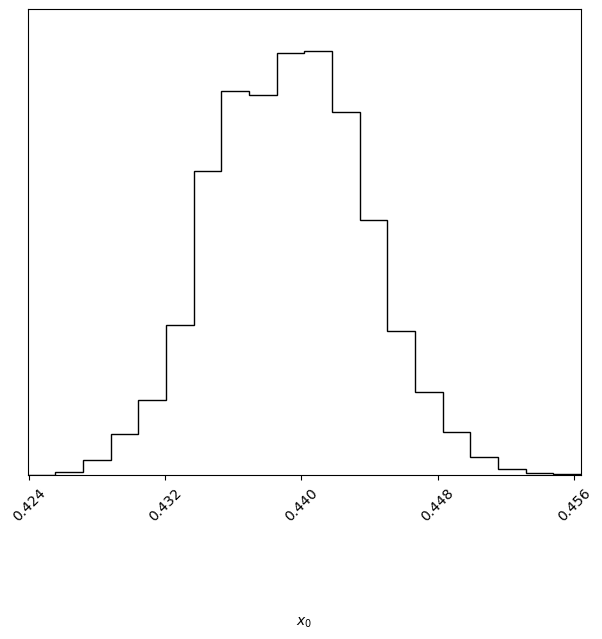

In [10]:
vp.plot();

In [14]:
# First, generate a large number of samples from the variational posterior:
n_samples = int(5e5)
Xs, _ = vp.sample(n_samples)

# Easily compute statistics such as moments, credible intervals, etc.
post_mean = np.mean(Xs, axis=0)  # Posterior mean
post_cov = np.cov(Xs.T)  # Posterior covariance matrix
moment = vp.moments()
print("The approximate posterior mean is:", post_mean)
print("moments?", moment)
#print("The approximate posterior covariance matrix is:\n", post_cov)

The approximate posterior mean is: [0.44014644]
moments? [[0.44014061]]


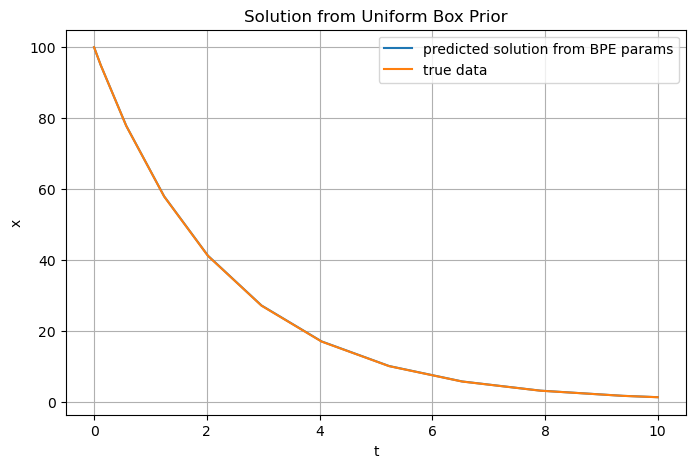

In [12]:
epsilon =  post_mean[0]
# beta = post_mean[1]

sol = odeint(diffyqs, initial_condition, t, args=(epsilon,))

plt.figure(figsize=(8,5))
plt.title("Solution from Uniform Box Prior")
plt.plot(t,sol.T[0], label = "predicted solution from BPE params")
plt.plot(t,x_true, label = "true data")
plt.grid()
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()

In [13]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = [scs.norm(loc = 2)]) # loc is location (mu), could also specify scale for standard deviation (sigma). List twice because 2d problem

vp, results = vbmc.optimize()

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10       -6726.65       506.86 665797926964798848.00        2        inf     start warm-up
     1         15         -38.61         0.01      3794.88        2        inf     
     2         20          -6.74         0.00        13.10        2        543     
     3         25          -6.73         0.00         0.01        2      0.395     
     4         30          -6.75         0.00         0.00        2      0.174     
     5         35          -6.73         0.00         0.00        2      0.102     
     6         40          -6.72         0.00         0.00        2     0.0718     
     7         45          -6.74         0.00         0.00        2     0.0566     end warm-up
     8         50          -6.73         0.00         0.01        2      0.477     
     9         55          -6.78        

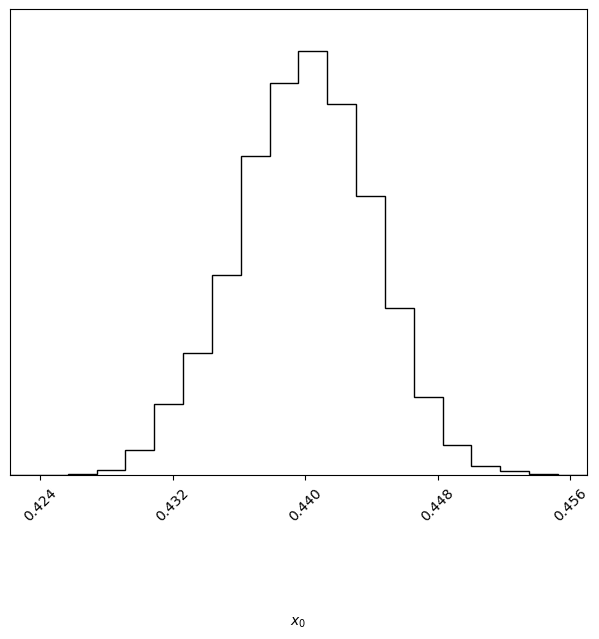

In [85]:
vp.plot();

The approximate posterior mean is: [0.439988]


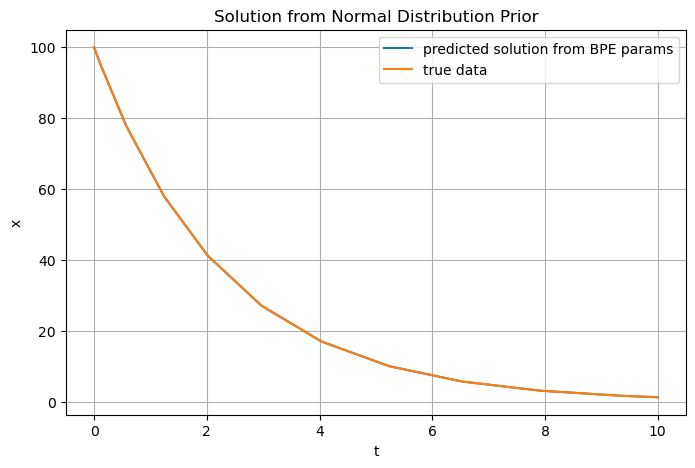

In [86]:
n_samples = int(5e5)
Xs, _ = vp.sample(n_samples)

post_mean = np.mean(Xs, axis=0)  # Posterior mean
print("The approximate posterior mean is:", post_mean)


epsilon =  post_mean[0]

sol = odeint(diffyqs, initial_condition, t, args=(epsilon,))

plt.figure(figsize=(8,5))
plt.title("Solution from Normal Distribution Prior")
plt.plot(t,sol.T[0], label = "predicted solution from BPE params")
plt.plot(t,x_true, label = "true data")
plt.grid()
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()